In [ ]:
#!pip install eli5

In [5]:
pwd

'/home/ec2-user/SageMaker/notebooks'

In [33]:
import pandas as pd
import numpy as np
import random
import pickle
import gc
#import psycopg2
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


import eli5
from eli5.sklearn import PermutationImportance
#import category_encoders as ce
#from catboost import CatBoostClassifier

In [6]:
path = '/home/ec2-user/SageMaker/RC-v1.2-Predictive-Modelling/pitcher_df_pickles/Greinke_df.pkl'

df = pd.read_pickle(path, compression='zip').reset_index()

df['fastball_target'] = (df['pitch_cat'] == 'fastball') * 1

df.head()

,index,pitch_type,game_date,pitcher,on_3b,on_2b,on_1b,outs_when_up,inning,catcher_id,sz_top,sz_bot,at_bat_number,pitch_number,bat_score,stand,inning_topbot,if_fielding_alignment,score_diff,bases_loaded,fastball_perc_faced,fastball_chase_perc,fastball_bip_swung_perc,fastball_taken_strike_perc,fastball_est_woba,fastball_babip,fastball_iso_value,breaking_perc_faced,breaking_chase_perc,breaking_bip_swung_perc,breaking_taken_strike_perc,breaking_est_woba,breaking_babip,breaking_iso_value,offspeed_perc_faced,offspeed_chase_perc,offspeed_bip_swung_perc,offspeed_taken_strike_perc,offspeed_est_woba,offspeed_babip,offspeed_iso_value,pitchout_perc_faced,balls,strikes,player_name,of_fielding_alignment,_count,count_cat,pitch_cat,overall_fastball_perc,count_cat_fastball_perc,overall_offspeed_perc,count_cat_offspeed_perc,overall_breaking_perc,count_cat_breaking_perc,pitch_count,L1_pitch_type,L1_pitch_result,L1_description,L1_pitch_zone,L1_batter_swung,L1_chased,L2_pitch_type,L2_pitch_result,L2_description,L2_pitch_zone,L2_chased,L3_pitch_type,L3_description,L3_pitch_zone,L3_chased,L5_fastball_perc,L15_fastball_perc,L5_breaking_perc,L15_breaking_perc,L5_offspeed_perc,L15_offspeed_perc,L5_strike_perc,L15_strike_perc,batting_order_slot,pitcher_AB,prev_ab_run_scored,prev_ab_homerun,prev_ab_walk,prev_ab_basehit,prev_ab_strikeout,PB_fastball,PB_breaking,PB_offspeed,month,year,on_base,fastball_target
0,8770,FF,2018-03-31,425844.0,0.0,0.0,0.0,0.0,1.0,425772.0,3.1773,1.2787,1.0,1.0,0.0,L,Top,Infield shift,0.0,0,65.776695,29.307116,39.467312,38.118214,0.40704,0.246085,0.221477,24.895977,36.879433,35.422344,28.474577,0.471,0.221649,0.293814,9.327323,37.572254,40.277779,17.708334,0.459517,0.28,0.226667,0.0,0,0,Zack Greinke,Standard,00,neutral,fastball,45.623501,49.248748,28.177458,24.207012,26.199041,26.544240,1.0,N/A,N/A,N/A,-1.0,-1.0,-1.0,N/A,N/A,N/A,-1.0,-1.0,N/A,N/A,-1.0,-1.0,48.126065,48.126065,28.892675,28.892675,22.981261,22.981261,46.405451,46.405451,1.0,0.0,0.0,0.0,0.0,0.0,0.0,62.500000,25.000000,12.500000,3,2018,0,1
1,8771,FF,2018-03-31,425844.0,0.0,0.0,0.0,0.0,1.0,425772.0,3.2751,1.7060,1.0,2.0,0.0,L,Top,Infield shift,0.0,0,65.776695,29.307116,39.467312,38.118214,0.40704,0.246085,0.221477,24.895977,36.879433,35.422344,28.474577,0.471,0.221649,0.293814,9.327323,37.572254,40.277779,17.708334,0.459517,0.28,0.226667,0.0,0,1,Zack Greinke,Standard,01,ahead,fastball,45.623501,43.985419,28.177458,25.030377,26.199041,30.984204,2.0,FF,S,called_strike,1.0,0.0,0.0,N/A,N/A,N/A,-1.0,-1.0,N/A,N/A,-1.0,-1.0,48.126065,48.126065,28.892675,28.892675,22.981261,22.981261,46.405451,46.405451,1.0,0.0,0.0,0.0,0.0,0.0,0.0,47.826087,39.130435,13.043478,3,2018,0,1
2,8772,FF,2018-03-31,425844.0,0.0,0.0,0.0,0.0,1.0,425772.0,3.3420,1.4434,1.0,3.0,0.0,L,Top,Infield shift,0.0,0,65.776695,29.307116,39.467312,38.118214,0.40704,0.246085,0.221477,24.895977,36.879433,35.422344,28.474577,0.471,0.221649,0.293814,9.327323,37.572254,40.277779,17.708334,0.459517,0.28,0.226667,0.0,1,1,Zack Greinke,Standard,11,ahead,fastball,45.623501,43.985419,28.177458,25.030377,26.199041,30.984204,3.0,FF,B,ball,12.0,0.0,0.0,FF,S,called_strike,1.0,0.0,N/A,N/A,-1.0,-1.0,48.126065,48.126065,28.892675,28.892675,22.981261,22.981261,46.405451,46.405451,1.0,0.0,0.0,0.0,0.0,0.0,0.0,47.826087,39.130435,13.043478,3,2018,0,1
3,8773,FF,2018-03-31,425844.0,0.0,0.0,0.0,0.0,1.0,425772.0,3.1773,1.2787,1.0,4.0,0.0,L,Top,Infield shift,0.0,0,65.776695,29.307116,39.467312,38.118214,0.40704,0.246085,0.221477,24.895977,36.879433,35.422344,28.474577,0.471,0.221649,0.293814,9.327323,37.572254,40.277779,17.708334,0.459517,0.28,0.226667,0.0,1,2,Zack Greinke,Standard,12,ahead,fastball,45.623501,43.985419,28.177458,25.030377,26.199041,30.984204,4.0,FF,S,called_strike,7.0,0.0,0.0,FF,B,ball,12.0,0.0,FF,called_strike,1.0,0.0,48.126065,48.126065,28.892675,28.892675,22.981261,22.981261,46.405451,46.405451,1.0,0.0,0.0,0.0,0.0,0.0,0.0,47.826087,39.130435,13.043478,3,2018,0,1
4,8774,SL,2018-03-31,425844.0,0.0,0.0,0.0,0.0,1.0,425772.0,

In [139]:
df.fastball_target.value_counts(normalize=True)

0    0.518739
1    0.481261
Name: fastball_target, dtype: float64

In [8]:
# #label encode some cat variables
from sklearn.preprocessing import LabelEncoder

cat_cols = ['stand', 'inning_topbot', 'if_fielding_alignment', 'of_fielding_alignment', 'count_cat',
           'L1_pitch_type', 'L1_pitch_result', 'L1_description', 'L1_pitch_zone', 'L1_batter_swung', 'L1_chased',
           'L2_pitch_type', 'L2_pitch_result','L2_description','L2_pitch_zone','L2_chased','L3_pitch_type',
           'L3_description','L3_pitch_zone','L3_chased', 'catcher_id', '_count', 'count_cat', 'pitch_cat', 
           'L1_pitch_zone', 'L2_pitch_zone', 'L3_pitch_zone', 'batting_order_slot', 'year', 'catcher_id']

le = LabelEncoder()

le_df = df.copy()

for col in cat_cols:
    try:
        le_df[col] = le.fit_transform(le_df[col])
    except:
        print(col)

le_df.head()

,index,pitch_type,game_date,pitcher,on_3b,on_2b,on_1b,outs_when_up,inning,catcher_id,sz_top,sz_bot,at_bat_number,pitch_number,bat_score,stand,inning_topbot,if_fielding_alignment,score_diff,bases_loaded,fastball_perc_faced,fastball_chase_perc,fastball_bip_swung_perc,fastball_taken_strike_perc,fastball_est_woba,fastball_babip,fastball_iso_value,breaking_perc_faced,breaking_chase_perc,breaking_bip_swung_perc,breaking_taken_strike_perc,breaking_est_woba,breaking_babip,breaking_iso_value,offspeed_perc_faced,offspeed_chase_perc,offspeed_bip_swung_perc,offspeed_taken_strike_perc,offspeed_est_woba,offspeed_babip,offspeed_iso_value,pitchout_perc_faced,balls,strikes,player_name,of_fielding_alignment,_count,count_cat,pitch_cat,overall_fastball_perc,count_cat_fastball_perc,overall_offspeed_perc,count_cat_offspeed_perc,overall_breaking_perc,count_cat_breaking_perc,pitch_count,L1_pitch_type,L1_pitch_result,L1_description,L1_pitch_zone,L1_batter_swung,L1_chased,L2_pitch_type,L2_pitch_result,L2_description,L2_pitch_zone,L2_chased,L3_pitch_type,L3_description,L3_pitch_zone,L3_chased,L5_fastball_perc,L15_fastball_perc,L5_breaking_perc,L15_breaking_perc,L5_offspeed_perc,L15_offspeed_perc,L5_strike_perc,L15_strike_perc,batting_order_slot,pitcher_AB,prev_ab_run_scored,prev_ab_homerun,prev_ab_walk,prev_ab_basehit,prev_ab_strikeout,PB_fastball,PB_breaking,PB_offspeed,month,year,on_base,fastball_target
0,8770,FF,2018-03-31,425844.0,0.0,0.0,0.0,0.0,1.0,0,3.1773,1.2787,1.0,1.0,0.0,0,1,0,0.0,0,65.776695,29.307116,39.467312,38.118214,0.40704,0.246085,0.221477,24.895977,36.879433,35.422344,28.474577,0.471,0.221649,0.293814,9.327323,37.572254,40.277779,17.708334,0.459517,0.28,0.226667,0.0,0,0,Zack Greinke,1,0,2,1,45.623501,49.248748,28.177458,24.207012,26.199041,26.544240,1.0,7,1,0,0,0,0,7,1,0,0,0,7,0,0,0,48.126065,48.126065,28.892675,28.892675,22.981261,22.981261,46.405451,46.405451,1,0.0,0.0,0.0,0.0,0.0,0.0,62.500000,25.000000,12.500000,3,0,0,1
1,8771,FF,2018-03-31,425844.0,0.0,0.0,0.0,0.0,1.0,0,3.2751,1.7060,1.0,2.0,0.0,0,1,0,0.0,0,65.776695,29.307116,39.467312,38.118214,0.40704,0.246085,0.221477,24.895977,36.879433,35.422344,28.474577,0.471,0.221649,0.293814,9.327323,37.572254,40.277779,17.708334,0.459517,0.28,0.226667,0.0,0,1,Zack Greinke,1,1,0,1,45.623501,43.985419,28.177458,25.030377,26.199041,30.984204,2.0,4,2,3,1,1,1,7,1,0,0,0,7,0,0,0,48.126065,48.126065,28.892675,28.892675,22.981261,22.981261,46.405451,46.405451,1,0.0,0.0,0.0,0.0,0.0,0.0,47.826087,39.130435,13.043478,3,0,0,1
2,8772,FF,2018-03-31,425844.0,0.0,0.0,0.0,0.0,1.0,0,3.3420,1.4434,1.0,3.0,0.0,0,1,0,0.0,0,65.776695,29.307116,39.467312,38.118214,0.40704,0.246085,0.221477,24.895977,36.879433,35.422344,28.474577,0.471,0.221649,0.293814,9.327323,37.572254,40.277779,17.708334,0.459517,0.28,0.226667,0.0,1,1,Zack Greinke,1,4,0,1,45.623501,43.985419,28.177458,25.030377,26.199041,30.984204,3.0,4,0,1,11,1,1,4,2,3,1,1,7,0,0,0,48.126065,48.126065,28.892675,28.892675,22.981261,22.981261,46.405451,46.405451,1,0.0,0.0,0.0,0.0,0.0,0.0,47.826087,39.130435,13.043478,3,0,0,1
3,8773,FF,2018-03-31,425844.0,0.0,0.0,0.0,0.0,1.0,0,3.1773,1.2787,1.0,4.0,0.0,0,1,0,0.0,0,65.776695,29.307116,39.467312,38.118214,0.40704,0.246085,0.221477,24.895977,36.879433,35.422344,28.474577,0.471,0.221649,0.293814,9.327323,37.572254,40.277779,17.708334,0.459517,0.28,0.226667,0.0,1,2,Zack Greinke,1,5,0,1,45.623501,43.985419,28.177458,25.030377,26.199041,30.984204,4.0,4,2,3,7,1,1,4,0,1,11,1,4,3,1,1,48.126065,48.126065,28.892675,28.892675,22.981261,22.981261,46.405451,46.405451,1,0.0,0.0,0.0,0.0,0.0,0.0,47.826087,39.130435,13.043478,3,0,0,1
4,8774,SL,2018-03-31,425844.0,0.0,0.0,0.0,0.0,1.0,0,3.3319,1.5432,1.0,5.0,0.0,0,1,0,0.0,0,65.776695,29.307116,39.467312,38.118214,0.40704,0.246085,0.221477,24.895977,36.879433,35.422344,28.474577,0.471,0.221649,0.293814,9.327323,37.572254,40.277779,17.708334,0.459517,0.28,0.226667,0.0,1,2,Zack Greinke,1,5,0,0,45.623501,43.985419,28.177458,25.030377,26.199041,30.984204,5.0,4,2,4,11,2,2,4,2,3,7,1,4,

## Split into Train/Test

In [11]:
len(df)

5870

In [16]:
#90% train / 10% held out test (will use validation set within train)

def train_test_split_by_date(df):
    train_idx = int(len(df) * 0.9)
    train_end_date = df.loc[train_idx].game_date
    train = df[df['game_date'] < train_end_date]
    test = df[df['game_date'] >= train_end_date]
    print('train shape: ' + str(train.shape))
    print('test shape: '+ str(test.shape))
    return train, test

In [17]:
train, test = train_test_split_by_date(le_df)

train shape: (5205, 93)
test shape: (665, 93)


In [18]:
#target = 'pitch_cat'
target = 'fastball_target'

drop_cols = ['index', 'player_name', 'game_date', 'pitch_cat', 'pitcher', 'pitch_type', target]

X = train.drop(columns=drop_cols)
X_test = test.drop(columns=drop_cols)

y = train[target]
y_test = test[target]

X.shape, X_test.shape, y.shape, y_test.shape

((5205, 86), (665, 86), (5205,), (665,))

## Scale the Float columns

In [19]:
scale_cols = ['fastball_perc_faced', 'fastball_chase_perc', 'fastball_bip_swung_perc', 'fastball_taken_strike_perc',
              'fastball_est_woba', 'fastball_babip', 'fastball_iso_value', 'breaking_perc_faced', 'breaking_chase_perc',
              'breaking_bip_swung_perc', 'breaking_taken_strike_perc', 'breaking_est_woba', 'breaking_babip',
              'breaking_iso_value', 'offspeed_perc_faced', 'offspeed_chase_perc', 'offspeed_bip_swung_perc',
              'offspeed_taken_strike_perc', 'offspeed_est_woba', 'offspeed_babip', 'offspeed_iso_value',
              'pitchout_perc_faced', 'overall_fastball_perc', 'count_cat_fastball_perc', 'overall_breaking_perc',
              'count_cat_breaking_perc', 'overall_offspeed_perc', 'count_cat_offspeed_perc', 'L5_fastball_perc',
              'L15_fastball_perc', 'L5_breaking_perc', 'L15_breaking_perc', 'L5_offspeed_perc', 'L15_offspeed_perc',
              'L5_strike_perc', 'L15_strike_perc', 'PB_fastball', 'PB_breaking', 'PB_offspeed']

scaler = RobustScaler()
X[scale_cols] = scaler.fit_transform(X[scale_cols].values)

X_test[scale_cols] = scaler.transform(X_test[scale_cols].values)

## Random Forest

In [20]:
%%time

#train/validation split
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.15, 
#                                                  random_state=42, stratify=y)

param_grid = {
    'n_estimators': [105, 120, 135],#  [50, 100,]
    'max_depth': [10], #
    'min_samples_split': [18, 21, 25],
    'min_samples_leaf': [7, 8],
    'class_weight': [None],#, 'balanced', 'balanced_subsample'],
    'warm_start': [False, True],
    'oob_score': [False],#, True],
    'bootstrap': [False]
}

rfc = RandomForestClassifier(n_jobs=-1, random_state=42, max_features='auto', 
                             criterion='gini')

search = GridSearchCV(
    estimator = rfc, 
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=10,
    return_train_score=True)

search.fit(X, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 168 out of 180 | elapsed:   29.0s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   30.3s finished


CPU times: user 5.94 s, sys: 808 ms, total: 6.75 s
Wall time: 30.8 s


In [21]:
search_results = pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')
search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_class_weight,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_oob_score,param_warm_start,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
15,1.581112,0.130565,0.334196,0.095694,False,None,10,7,25,120,False,True,"{'bootstrap': False, 'class_weight': None, 'ma...",0.597889,0.591171,0.597502,0.608654,0.621154,0.603266,0.010557,1,0.870526,0.875811,0.888809,0.872989,0.884754,0.878578,0.007022
14,1.554220,0.086204,0.410868,0.104125,False,None,10,7,25,120,False,False,"{'bootstrap': False, 'class_weight': None, 'ma...",0.597889,0.591171,0.597502,0.608654,0.621154,0.603266,0.010557,1,0.870526,0.875811,0.888809,0.872989,0.884754,0.878578,0.007022
13,1.335310,0.106022,0.253464,0.111138,False,None,10,7,25,105,False,True,"{'bootstrap': False, 'class_weight': None, 'ma...",0.593090,0.592131,0.603266,0.604808,0.623077,0.603266,0.011156,1,0.870526,0.875571,0.887848,0.872509,0.883313,0.877953,0.006590
12,1.470782,0.185887,0.241745,0.071539,False,None,10,7,25,105,False,False,"{'bootstrap': False, 'class_weight': None, 'ma...",0.593090,0.592131,0.603266,0.604808,0.623077,0.603266,0.011156,1,0.870526,0.875571,0.887848,0.872509,0.883313,0.877953,0.006590
17,1.738699,0.175030,0.331324,0.079021,False,None,10,7,25,135,False,True,"{'bootstrap': False, 'class_weight': None, 'ma...",0.593090,0.595010,0.599424,0.605769,0.619231,0.602498,0.009430,5,0.871006,0.876772,0.889769,0.875630,0.884994,0.879634,0.006784


In [22]:
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

def con_matrix_analysis(model, X, X_test, y, y_test):
  
    model.fit(X, y)
    y_pred = model.predict(X_test)
  
    print(classification_report(y_test, y_pred, target_names=['Fastball', 'Not Fastball']))

    con_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                              columns=['Predicted Fastball', 'Predicted Not Fastball'],
                              index=['Actual Fastball', 'Actual Not Fastball'])
                            
    sns.heatmap(data=con_matrix, cmap='cool')
    plt.show();
    return con_matrix

In [23]:
def get_accuracy_metrics(model, X, y, X_test, y_test):
    model.fit(X, y)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    
    r2_test = model.score(X_test, y_test)
    print('Test R2 score: ' + str(r2_test))
    
    accuracy = accuracy_score(y_pred, y_test)
    print('Accuracy ' + str(accuracy))
    
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print('Roc_Auc score: ' + str(roc_auc))
    
    return r2_test, accuracy, roc_auc

              precision    recall  f1-score   support

    Fastball       0.67      0.76      0.71       372
Not Fastball       0.63      0.52      0.57       293

   micro avg       0.65      0.65      0.65       665
   macro avg       0.65      0.64      0.64       665
weighted avg       0.65      0.65      0.65       665



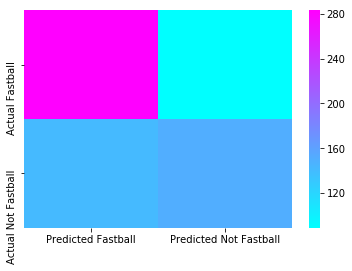

,Predicted Fastball,Predicted Not Fastball
Actual Fastball,283,89
Actual Not Fastball,142,151


In [24]:
model = search.best_estimator_

con_matrix_analysis(model, X, X_test, y, y_test)

In [25]:
get_accuracy_metrics(model, X, y, X_test, y_test)

Test R2 score: 0.6526315789473685
Accuracy 0.6526315789473685
Roc_Auc score: 0.6664097765055599


(0.6526315789473685, 0.6526315789473685, 0.6664097765055599)

## Gradient Boosted Classifier

In [158]:
param_grid = {
    'loss' : ['deviance'],# 'exponential'],
    'learning_rate': [0.01],
    'n_estimators': [30, 40, 60],
    'subsample': [.8],
    'min_samples_split': [4, 6, 8],
    'min_samples_leaf': [8, 10, 12],
    'max_depth': [3, 4, 6],
    'max_features': [.75]
}

gbc = GradientBoostingClassifier(random_state=42)

search = GridSearchCV(
    estimator = gbc, 
    param_grid = param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=5,
    return_train_score=True
)

search.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   42.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'loss': ['deviance'], 'learning_rate': [0.01], 'n_estimators': [30, 40, 60], 'subsample': [0.8], 'min_samples_split': [4, 6, 8], 'min_samples_leaf': [8, 10, 12], 'max_depth': [3, 4, 6], 'max_features': [0.75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=5)

In [159]:
search_results = pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')
search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_loss,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
65,3.380526,0.069480,0.019543,0.000261,0.01,deviance,6,0.75,10,4,60,0.8,"{'learning_rate': 0.01, 'loss': 'deviance', 'm...",0.592131,0.582534,0.591739,0.624038,0.615385,0.601153,0.015765,1,0.763392,0.758828,0.764890,0.742617,0.756543,0.757254,0.007915
78,1.709993,0.029167,0.017696,0.000105,0.01,deviance,6,0.75,12,8,30,0.8,"{'learning_rate': 0.01, 'loss': 'deviance', 'm...",0.592131,0.603647,0.586936,0.604808,0.618269,0.601153,0.010917,1,0.728321,0.731684,0.735831,0.716447,0.724130,0.727282,0.006647
68,3.360764,0.033838,0.019194,0.000183,0.01,deviance,6,0.75,10,6,60,0.8,"{'learning_rate': 0.01, 'loss': 'deviance', 'm...",0.592131,0.582534,0.591739,0.624038,0.615385,0.601153,0.015765,1,0.763392,0.758828,0.764890,0.742617,0.756543,0.757254,0.007915
71,3.373185,0.035516,0.019299,0.000193,0.01,deviance,6,0.75,10,8,60,0.8,"{'learning_rate': 0.01, 'loss': 'deviance', 'm...",0.592131,0.582534,0.591739,0.624038,0.615385,0.601153,0.015765,1,0.763392,0.758828,0.764890,0.742617,0.756543,0.757254,0.007915
75,1.711048,0.035026,0.017445,0.000104,0.01,deviance,6,0.75,12,6,30,0.8,"{'learning_rate': 0.01, 'loss': 'deviance', 'm...",0.592131,0.603647,0.586936,0.604808,0.618269,0.601153,0.010917,1,0.728321,0.731684,0.735831,0.716447,0.724130,0.727282,0.006647


              precision    recall  f1-score   support

    Fastball       0.64      0.76      0.69       372
Not Fastball       0.60      0.45      0.52       293

   micro avg       0.62      0.62      0.62       665
   macro avg       0.62      0.61      0.60       665
weighted avg       0.62      0.62      0.61       665



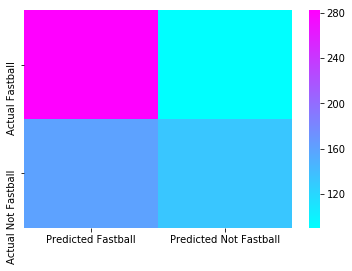

,Predicted Fastball,Predicted Not Fastball
Actual Fastball,282,90
Actual Not Fastball,160,133


In [160]:
model = search.best_estimator_
con_matrix_analysis(model, X, X_test, y, y_test)

In [161]:
get_accuracy_metrics(model, X, y, X_test, y_test)

Test R2 score: 0.6240601503759399
Accuracy 0.6240601503759399
Roc_Auc score: 0.6559965503321222


(0.6240601503759399, 0.6240601503759399, 0.6559965503321222)

## Linear Support Vector Machine

In [ ]:
#1 hot encode instead of label encode:

In [154]:
from sklearn.svm import LinearSVC

param_grid = {
    'penalty': ['l1'],#, 'l1'],
    'loss': ['squared_hinge'],#'hinge'
    'dual': [False],
    'tol': [0.0005, 0.0001, 0.00005, 0.000001],
    'C': [2.5, 4.0, 5.0],
    #'multi_class': ['ovr'],
    'class_weight': [None],
    'max_iter': [300, 500, 800],#, 1500, 2000, 2500],
    'fit_intercept': [False]
}

svm = LinearSVC(random_state=42, verbose=50)

search = GridSearchCV(
    estimator = svm, 
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=4,
    verbose=10,
    return_train_score=True
)

search.fit(X, y)

Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 128 out of 144 | elapsed:    8.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    9.6s finished


[LibLinear]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=50),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l1'], 'loss': ['squared_hinge'], 'dual': [False], 'tol': [0.0005, 0.0001, 5e-05, 1e-06], 'C': [2.5, 4.0, 5.0], 'class_weight': [None], 'max_iter': [300, 500, 800], 'fit_intercept': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=10)

In [155]:
search_results = pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')
search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_dual,param_fit_intercept,param_loss,param_max_iter,param_penalty,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
17,0.886324,0.006941,0.017312,0.000295,4,None,False,False,squared_hinge,500,l1,0.0001,"{'C': 4.0, 'class_weight': None, 'dual': False...",0.605991,0.583397,0.598002,0.629516,0.604227,0.016696,1,0.633615,0.639088,0.631404,0.621926,0.631508,0.006199
16,0.899037,0.028565,0.017253,0.000232,4,None,False,False,squared_hinge,500,l1,0.0005,"{'C': 4.0, 'class_weight': None, 'dual': False...",0.605991,0.583397,0.598002,0.629516,0.604227,0.016696,1,0.633615,0.639088,0.631404,0.621926,0.631508,0.006199
18,0.886922,0.005883,0.017411,0.000598,4,None,False,False,squared_hinge,500,l1,5e-05,"{'C': 4.0, 'class_weight': None, 'dual': False...",0.605991,0.583397,0.598002,0.629516,0.604227,0.016696,1,0.633615,0.639088,0.631404,0.621926,0.631508,0.006199
19,0.887078,0.005620,0.017334,0.000231,4,None,False,False,squared_hinge,500,l1,1e-06,"{'C': 4.0, 'class_weight': None, 'dual': False...",0.605991,0.583397,0.598002,0.629516,0.604227,0.016696,1,0.633615,0.639088,0.631404,0.621926,0.631508,0.006199
8,1.353190,0.019033,0.017158,0.000723,2.5,None,False,False,squared_hinge,800,l1,0.0005,"{'C': 2.5, 'class_weight': None, 'dual': False...",0.603687,0.583397,0.600307,0.626441,0.603458,0.015333,5,0.633359,0.639600,0.632172,0.622182,0.631828,0.006243


[LibLinear]              precision    recall  f1-score   support

    Fastball       0.68      0.60      0.64       372
Not Fastball       0.56      0.64      0.60       293

   micro avg       0.62      0.62      0.62       665
   macro avg       0.62      0.62      0.62       665
weighted avg       0.62      0.62      0.62       665



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


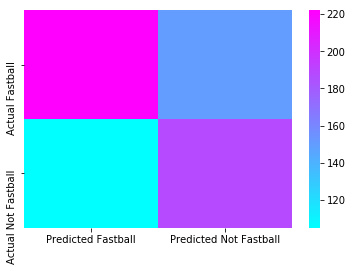

,Predicted Fastball,Predicted Not Fastball
Actual Fastball,222,150
Actual Not Fastball,105,188


In [156]:
model = search.best_estimator_
con_matrix_analysis(model, X, X_test, y, y_test)

In [157]:
#get_accuracy_metrics(model, X, y, X_test, y_test)

## Feature Importances

In [27]:
model.fit(X, y)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=7, min_samples_split=25,
            min_weight_fraction_leaf=0.0, n_estimators=105, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

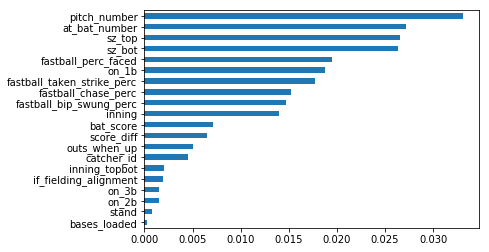

In [30]:
importances = pd.Series(model.feature_importances_, X.columns)
importances.head(20).sort_values().plot.barh()
plt.show()

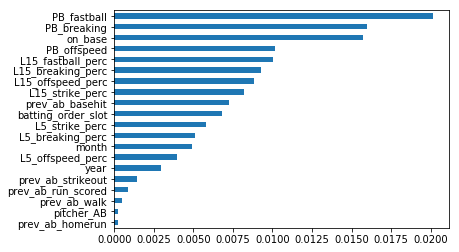

In [31]:
importances = pd.Series(model.feature_importances_, X.columns)
importances.tail(20).sort_values().plot.barh()
plt.show()

In [36]:
%%time

permuter = PermutationImportance(model, scoring='accuracy', cv='prefit', 
                                 n_iter=1, random_state=42)

permuter.fit(X, y)

feature_names = train.drop(columns=drop_cols).columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

CPU times: user 10.4 s, sys: 778 ms, total: 11.2 s
Wall time: 9.24 s


In [38]:
#Make a dataframe of the elie_weights importances:
eli_importances_df = eli5.explain_weights_df(permuter, feature_names=feature_names)

#inspect the 20 features w/ most importance
eli_importances_df.sort_values(by='weight', ascending=False).head(20)

,feature,weight,std
0,at_bat_number,0.022094,0.0
1,pitch_count,0.021710,0.0
2,breaking_babip,0.021134,0.0
3,on_1b,0.020365,0.0
4,strikes,0.017675,0.0
5,on_base,0.016715,0.0
6,count_cat_fastball_perc,0.014217,0.0
7,_count,0.013833,0.0
8,sz_bot,0.013064,0.0
9,inning,0.012872,0.0


In [39]:
#inspect the 20 features w/ least importance
eli_importances_df.sort_values(by='weight', ascending=False).tail(20)

,feature,weight,std
66,overall_breaking_perc,0.001537,0.0
67,L1_batter_swung,0.001537,0.0
68,pitchout_perc_faced,0.001537,0.0
69,L3_chased,0.001537,0.0
70,L5_breaking_perc,0.001153,0.0
71,L2_chased,0.001153,0.0
72,month,0.001153,0.0
73,on_2b,0.000768,0.0
74,L1_chased,0.000576,0.0
77,prev_ab_run_scored,0.000384,0.0
